In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [ ]:
import cv2

In [ ]:
import tensorflow as t

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
from tensorflow.keras import optimizers

In [ ]:
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [ ]:
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/images/plate.xml')
# add the path to 'india_license_plate.xml' file.

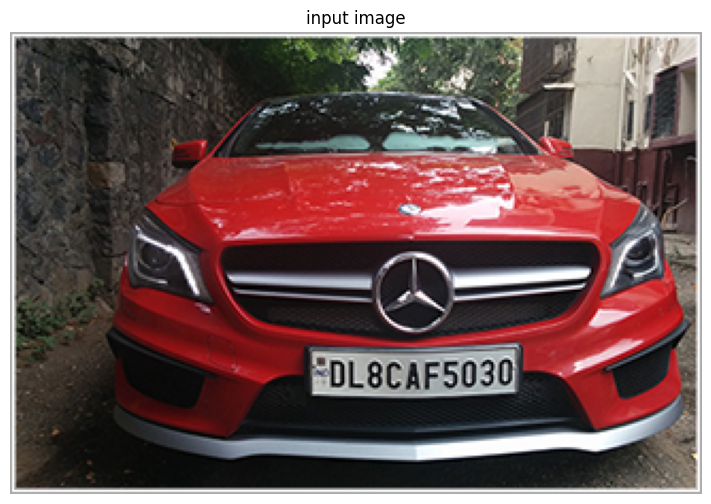

In [ ]:
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('/content/drive/MyDrive/images/car.jpg')
display(img, 'input image')

In [ ]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        return plate_img, plate

In [ ]:
output_img, plate = detect_plate (img, '/content/drive/MyDrive/images/car.jpg')

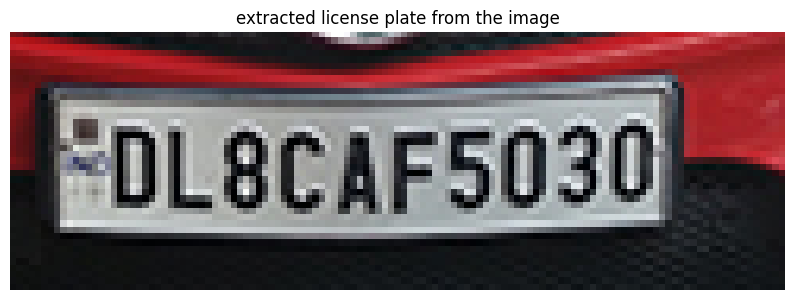

In [ ]:
display(plate, 'extracted license plate from the image')

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :

        # detects contour in binary image and returns the coordinates of rectangle enc
         intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        # checking the dimensions of the contour to filter out the characters by contour's size
         if intWidth > lower_width or intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
              x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

              char_copy = np.zeros((44,24))
              # extracting each character using the enclosing rectangle's coordinates.
              char = img[intY:intY+intHeight, intX:intX+intWidth]
              char = cv2.resize(char, (20, 40))

              cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
              plt.imshow(ii, cmap='gray')

              # Make result formatted for classification: invert colors
              char = cv2.subtract(255, char)

              # Resize the image to 24x44 with black border
              char_copy[2:42, 2:22] = char
              char_copy[0:2, :] = 0
              char_copy[:, 0:2] = 0
              char_copy[42:44, :] = 0
              char_copy[:, 22:24] = 0

              img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)


    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Find characters in the resulting images
from google.colab.patches import cv2_imshow
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))

    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp,cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)
    return char_list


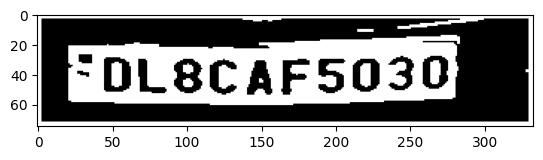

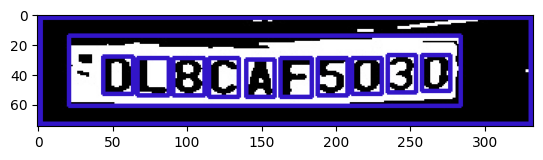

In [ ]:
char = segment_characters(plate)

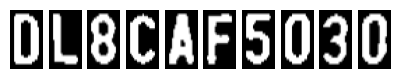

In [ ]:
for i in range(3,13):
    plt.subplot(1, 13, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [ ]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '/content/drive/MyDrive/images/datap'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 912 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [ ]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf

In [ ]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.model.stop_training = True

In [ ]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator,
      epochs =80, verbose=1, callbacks=callbacks)

<ipython-input-30-4e35815fa0f7>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
912/912 [==============================] - 512s 549ms/step - loss: 3.5843 - custom_f1score: 0.0768 - val_loss: 3.5891 - val_custom_f1score: 0.0298
Epoch 2/50
912/912 [==============================] - 10s 11ms/step - loss: 3.5713 - custom_f1score: 0.0789 - val_loss: 3.5888 - val_custom_f1score: 0.0268
Epoch 3/50
912/912 [==============================] - 10s 11ms/step - loss: 3.5625 - custom_f1score: 0.0789 - val_loss: 3.6013 - val_custom_f1score: 0.0283
Epoch 4/50
912/912 [==============================] - 10s 11ms/step - loss: 3.5609 - custom_f1score: 0.0789 - val_loss: 3.6025 - val_custom_f1score: 0.0298
Epoch 5/50
912/912 [==============================] - 9s 10ms/step - loss: 3.5595 - custom_f1score: 0.0789 - val_loss: 3.6031 - val_custom_f1score: 0.0268
Epoch 6/50
912/912 [==============================] - 10s 11ms/step - loss: 3.5587 - custom_f1score: 0.0789 - val_loss: 3.6078 - val_custom_f1score: 0.0268
Epoch 7/50
912/912 [==============================] - 11s 12ms/

In [ ]:
def fix_dimension(img):
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

plate_number =''

def show_results():
    global plate_number
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char):
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = model.predict(img)[0]
        classes_x=np.argmax(y_,axis=0)
        character = dic[classes_x]
        output.append(character)

        plate_number=''.join(output)

    return plate_number


print(show_results())

1/1 [==============================] - 0s 19ms/step
ZZZZZZZZZZZZZ


In [ ]:
plt.figure(figsize=(10,8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

1/1 [==============================] - 0s 31ms/step


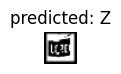

1/1 [==============================] - 0s 21ms/step


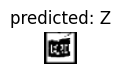

1/1 [==============================] - 0s 19ms/step


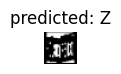

1/1 [==============================] - 0s 23ms/step


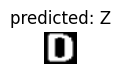

1/1 [==============================] - 0s 32ms/step


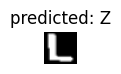

1/1 [==============================] - 0s 22ms/step


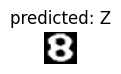

1/1 [==============================] - 0s 23ms/step


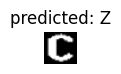

1/1 [==============================] - 0s 23ms/step


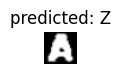

1/1 [==============================] - 0s 20ms/step


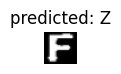

1/1 [==============================] - 0s 22ms/step


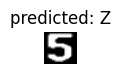

1/1 [==============================] - 0s 27ms/step


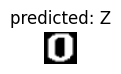

1/1 [==============================] - 0s 29ms/step


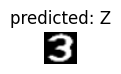

1/1 [==============================] - 0s 28ms/step


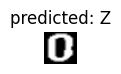

In [ ]:
for i,ch in enumerate(char):
  img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
  plt.subplot(3,13,i+1)
  plt.imshow(img,cmap='gray')
  plt.title(f'predicted: {show_results()[i]}')
  plt.axis('off')
  plt.show()

In [ ]:
plate_number

'ZZZZZZZZZZZZZ'

In [ ]:
import pandas as pd

In [ ]:

df=pd.read_csv("/content/vahan1.csv - vahan.csv")
out = df[ df.Number_Plate == plate_number ]


if out.empty == True :
  print(" not found")
else:
  print(out)




 not found
